C:\Users\rajpa\AppData\Local\Temp\ipykernel_29908\768890876.py:62: RuntimeWarning: divide by zero encountered in log
  E_F = material["E_g"] - k_B * T * np.log(N_c / N_D)
C:\Users\rajpa\AppData\Local\Temp\ipykernel_29908\768890876.py:62: RuntimeWarning: invalid value encountered in scalar multiply
  E_F = material["E_g"] - k_B * T * np.log(N_c / N_D)
C:\Users\rajpa\AppData\Local\Temp\ipykernel_29908\768890876.py:145: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


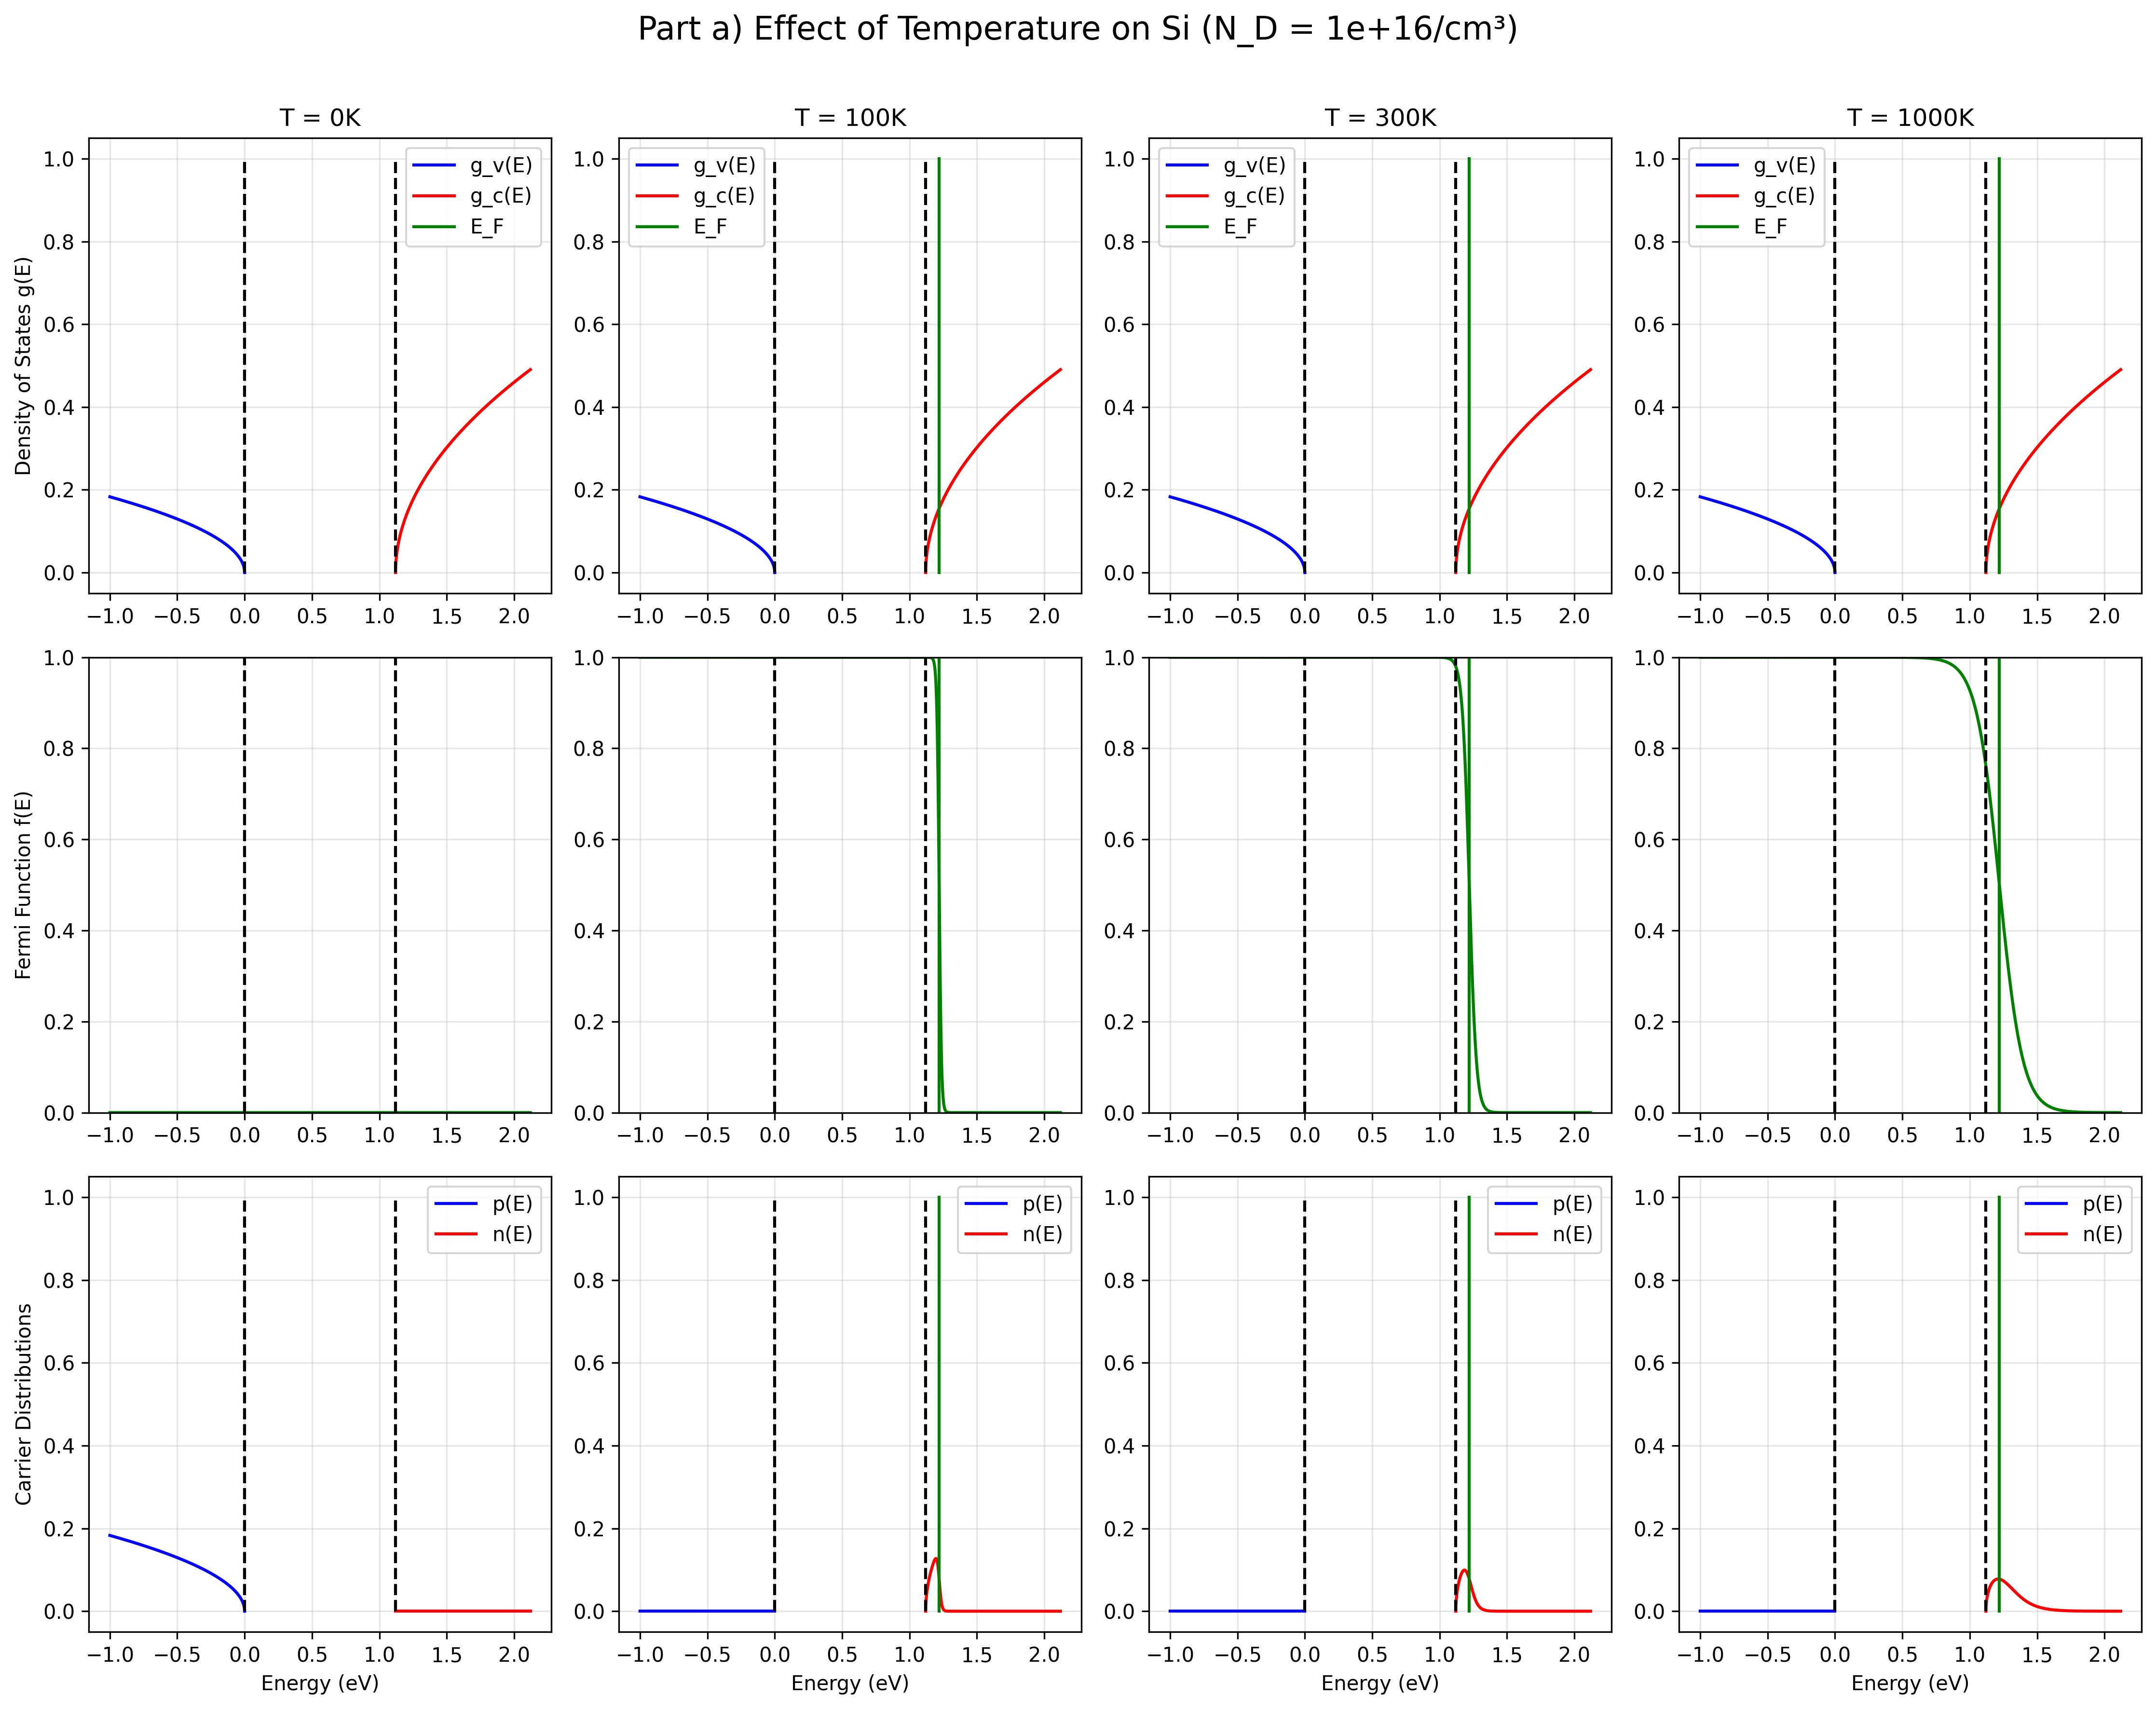

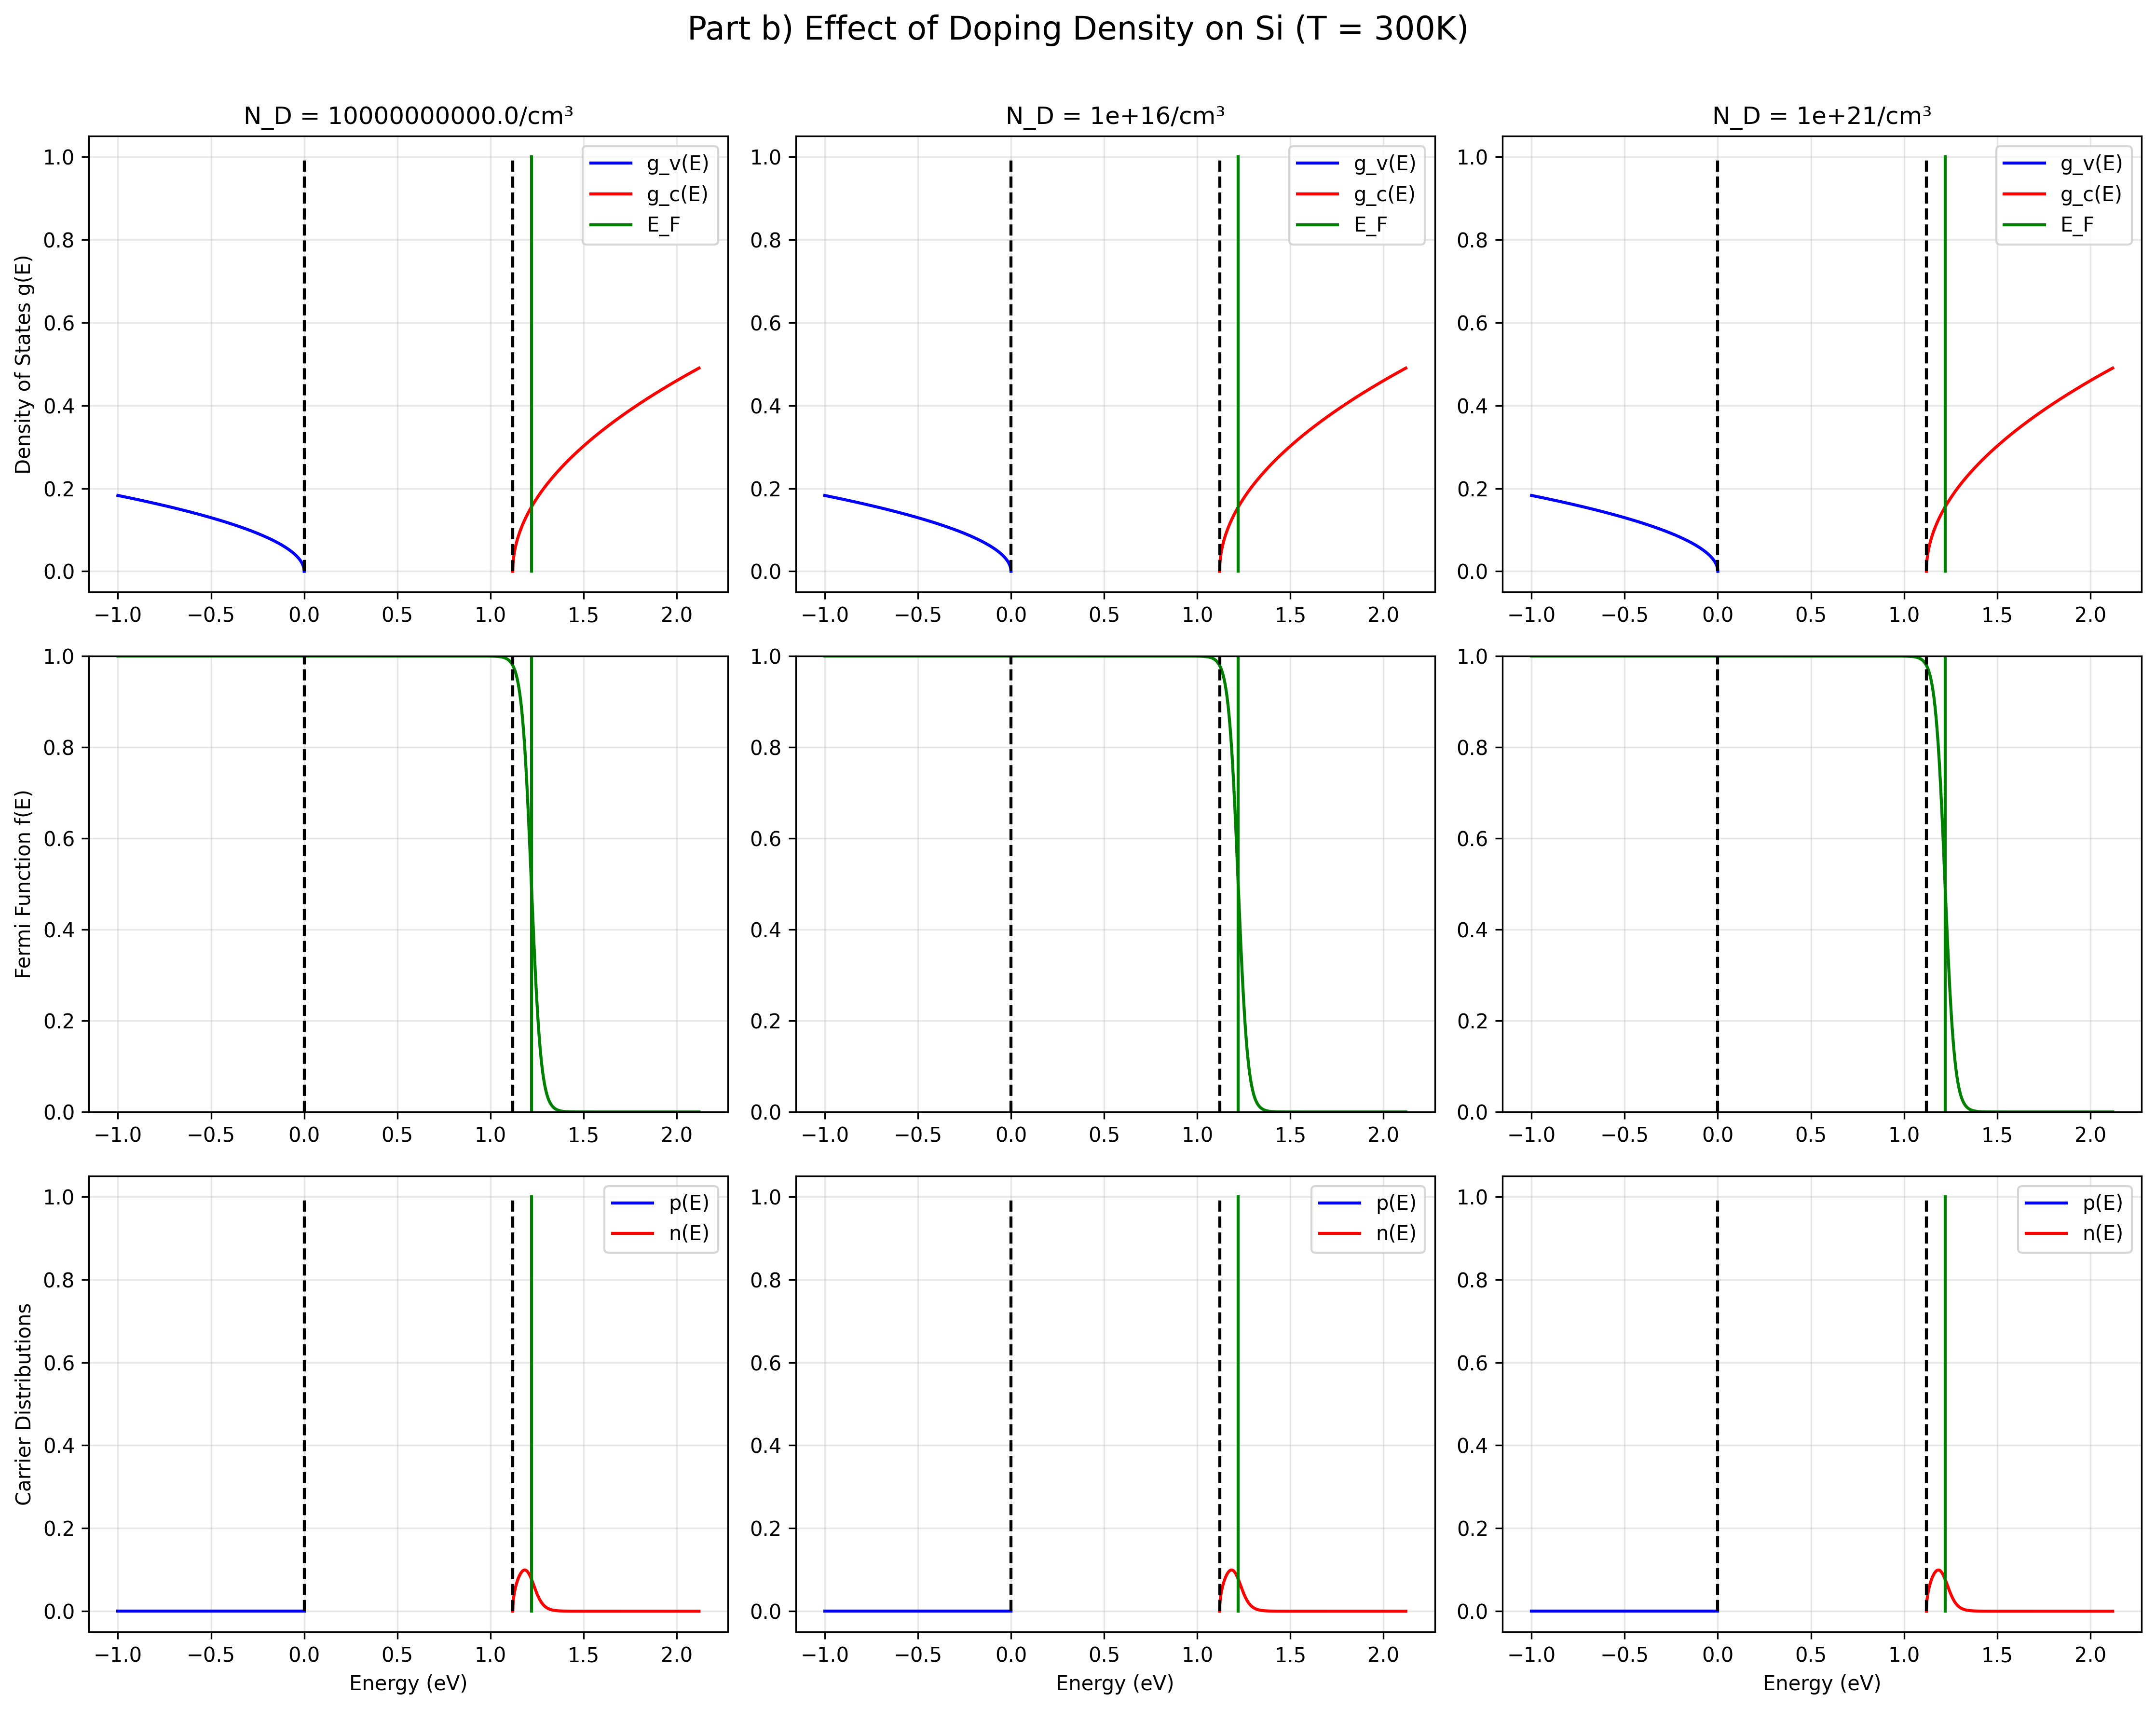

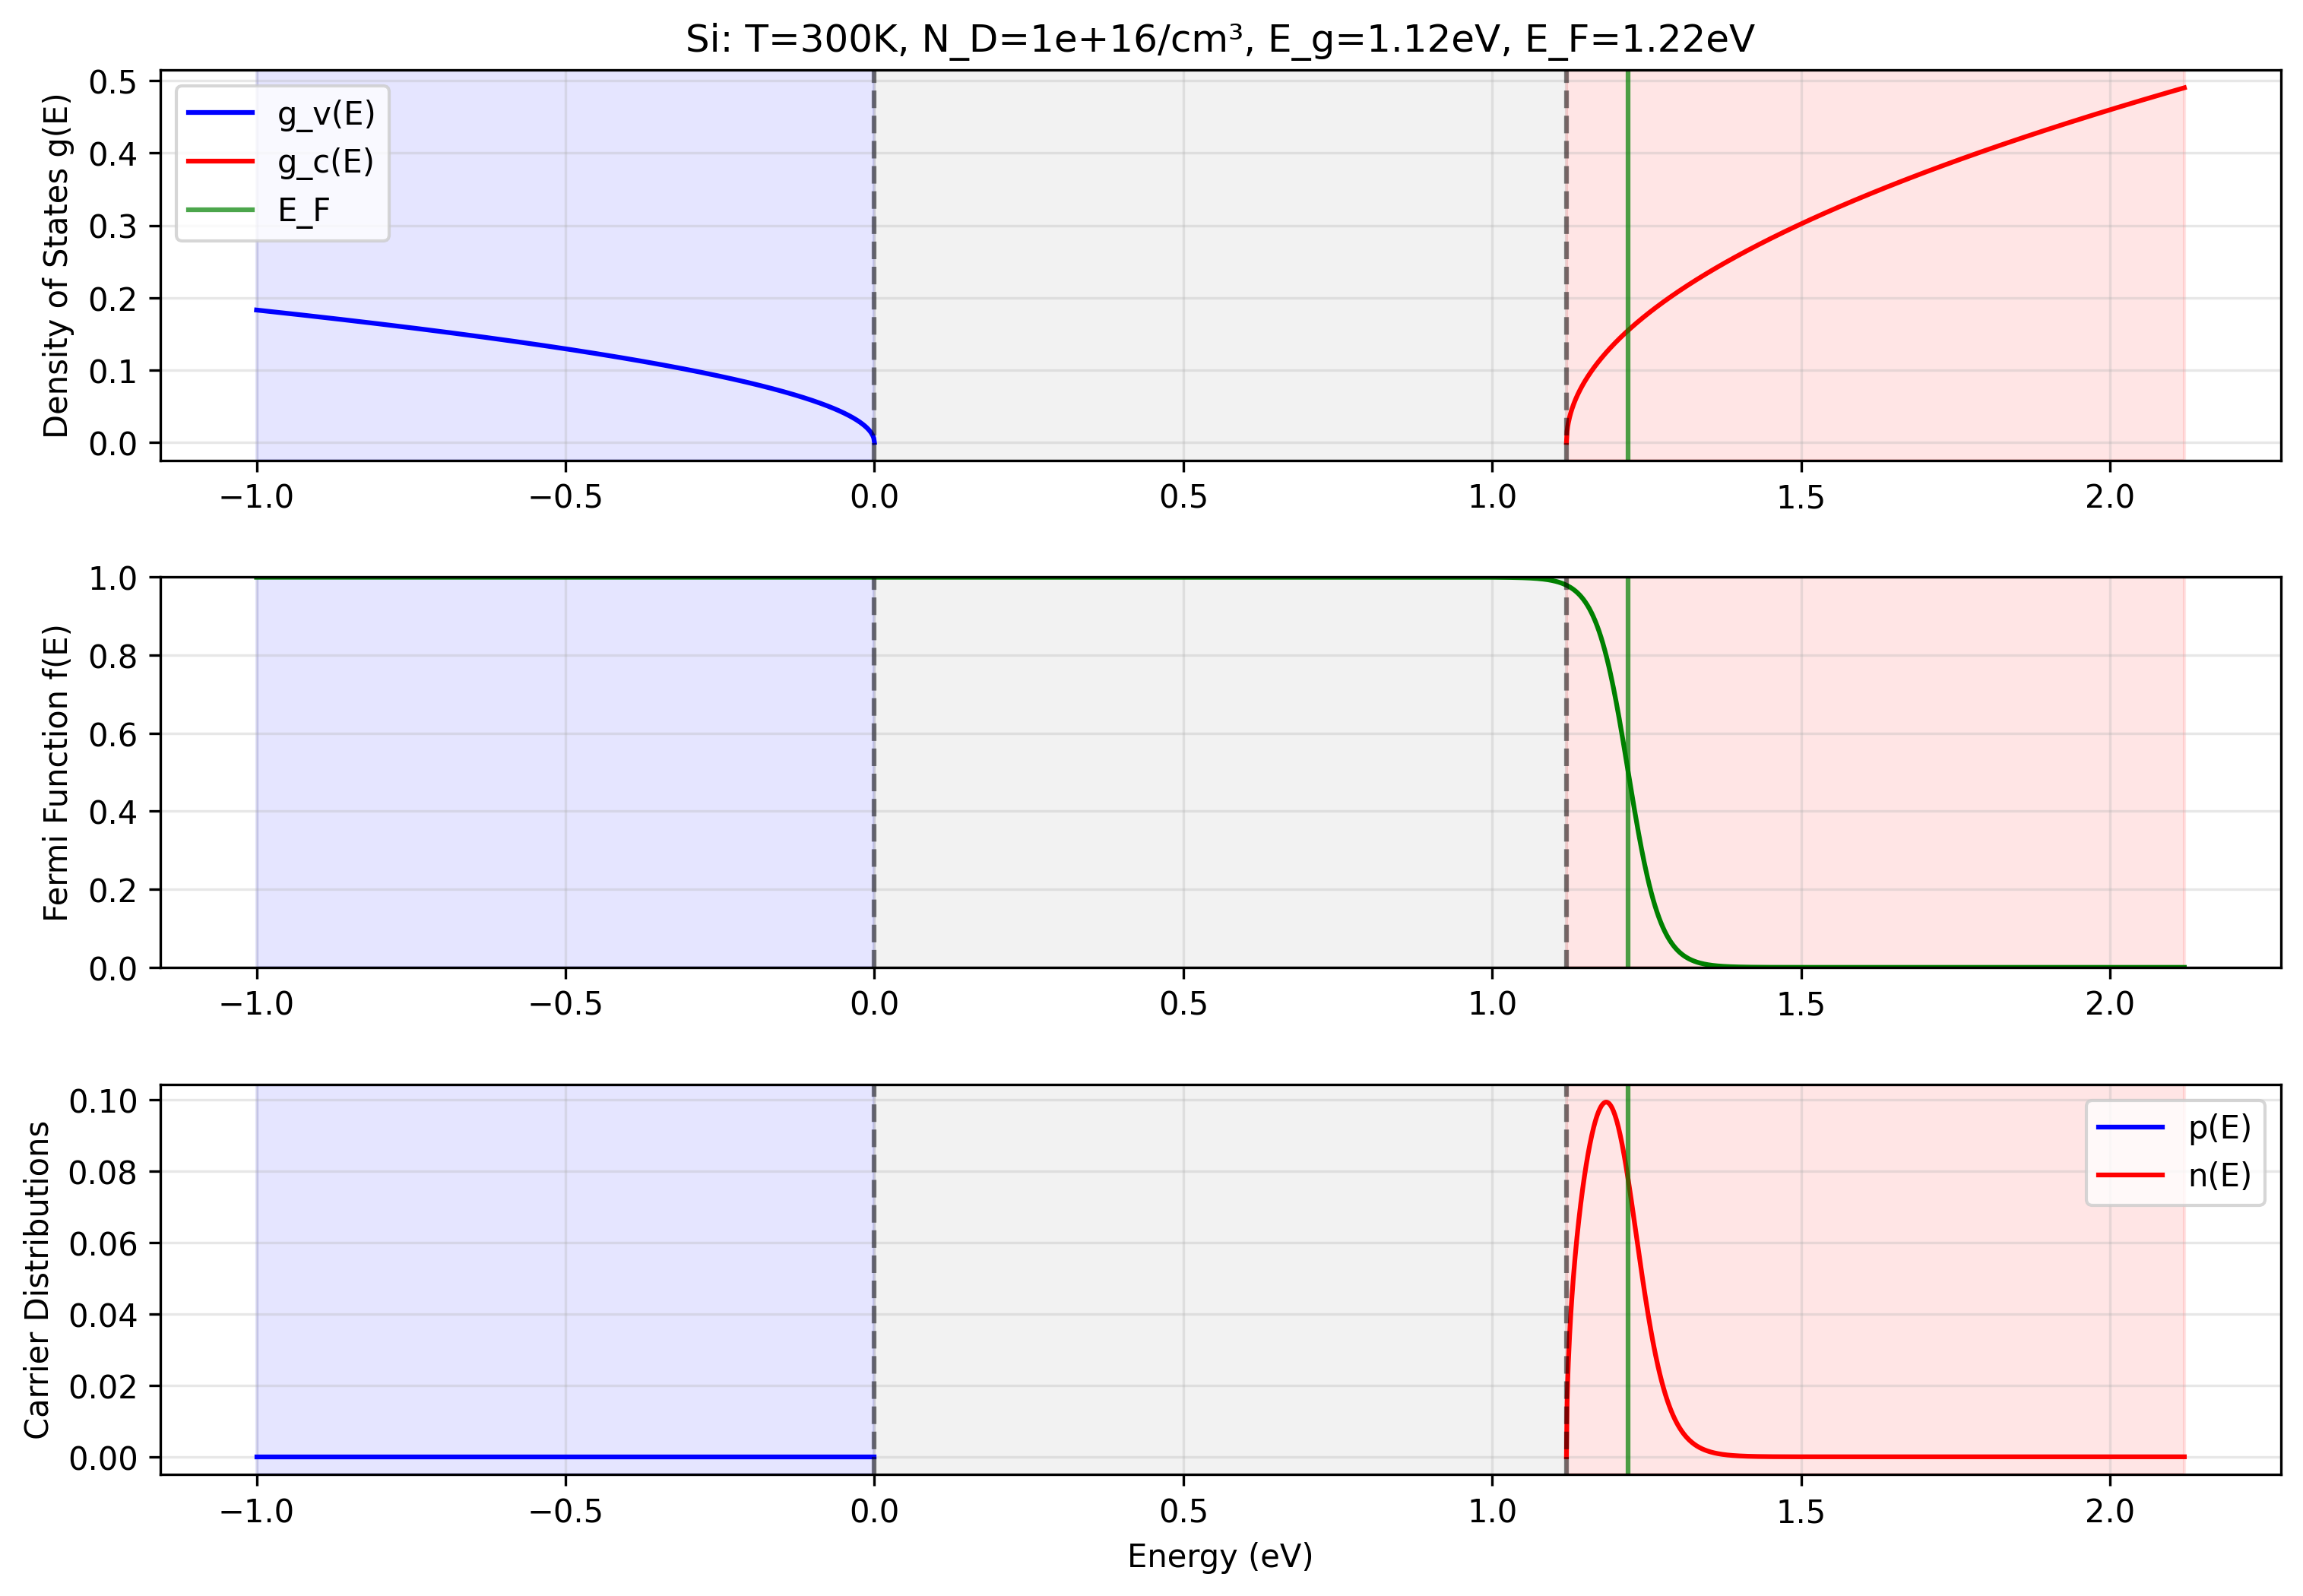

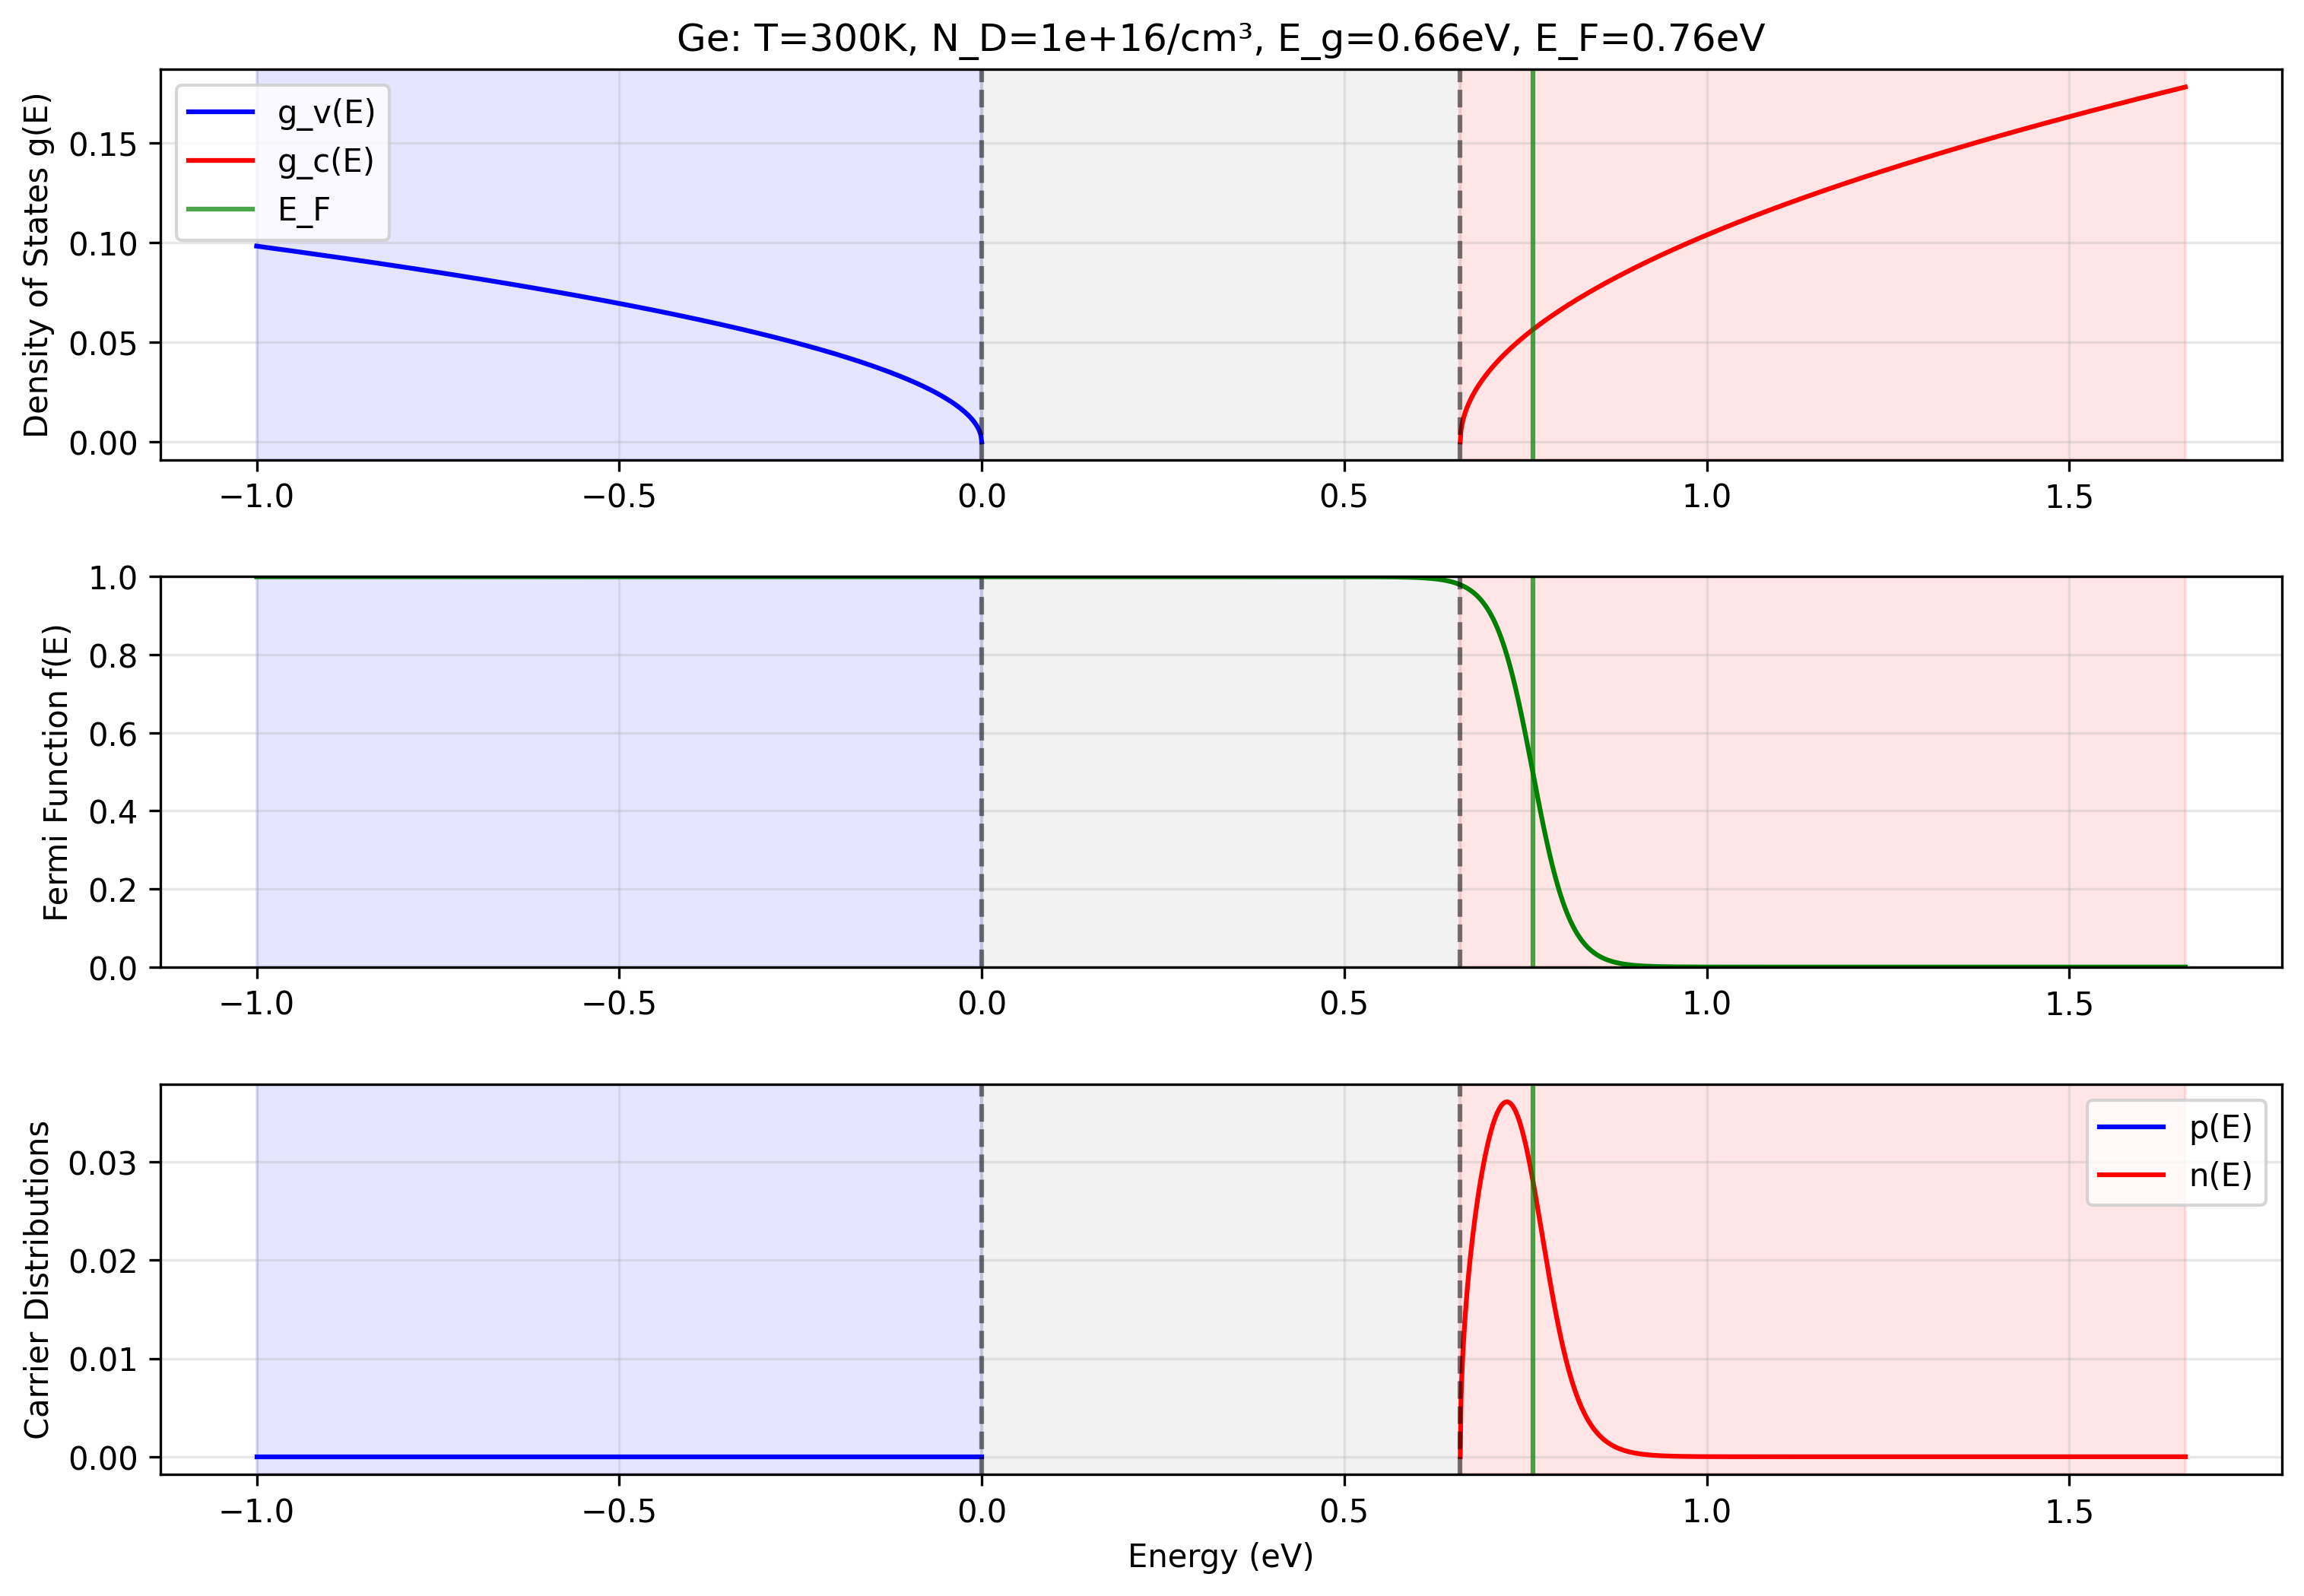

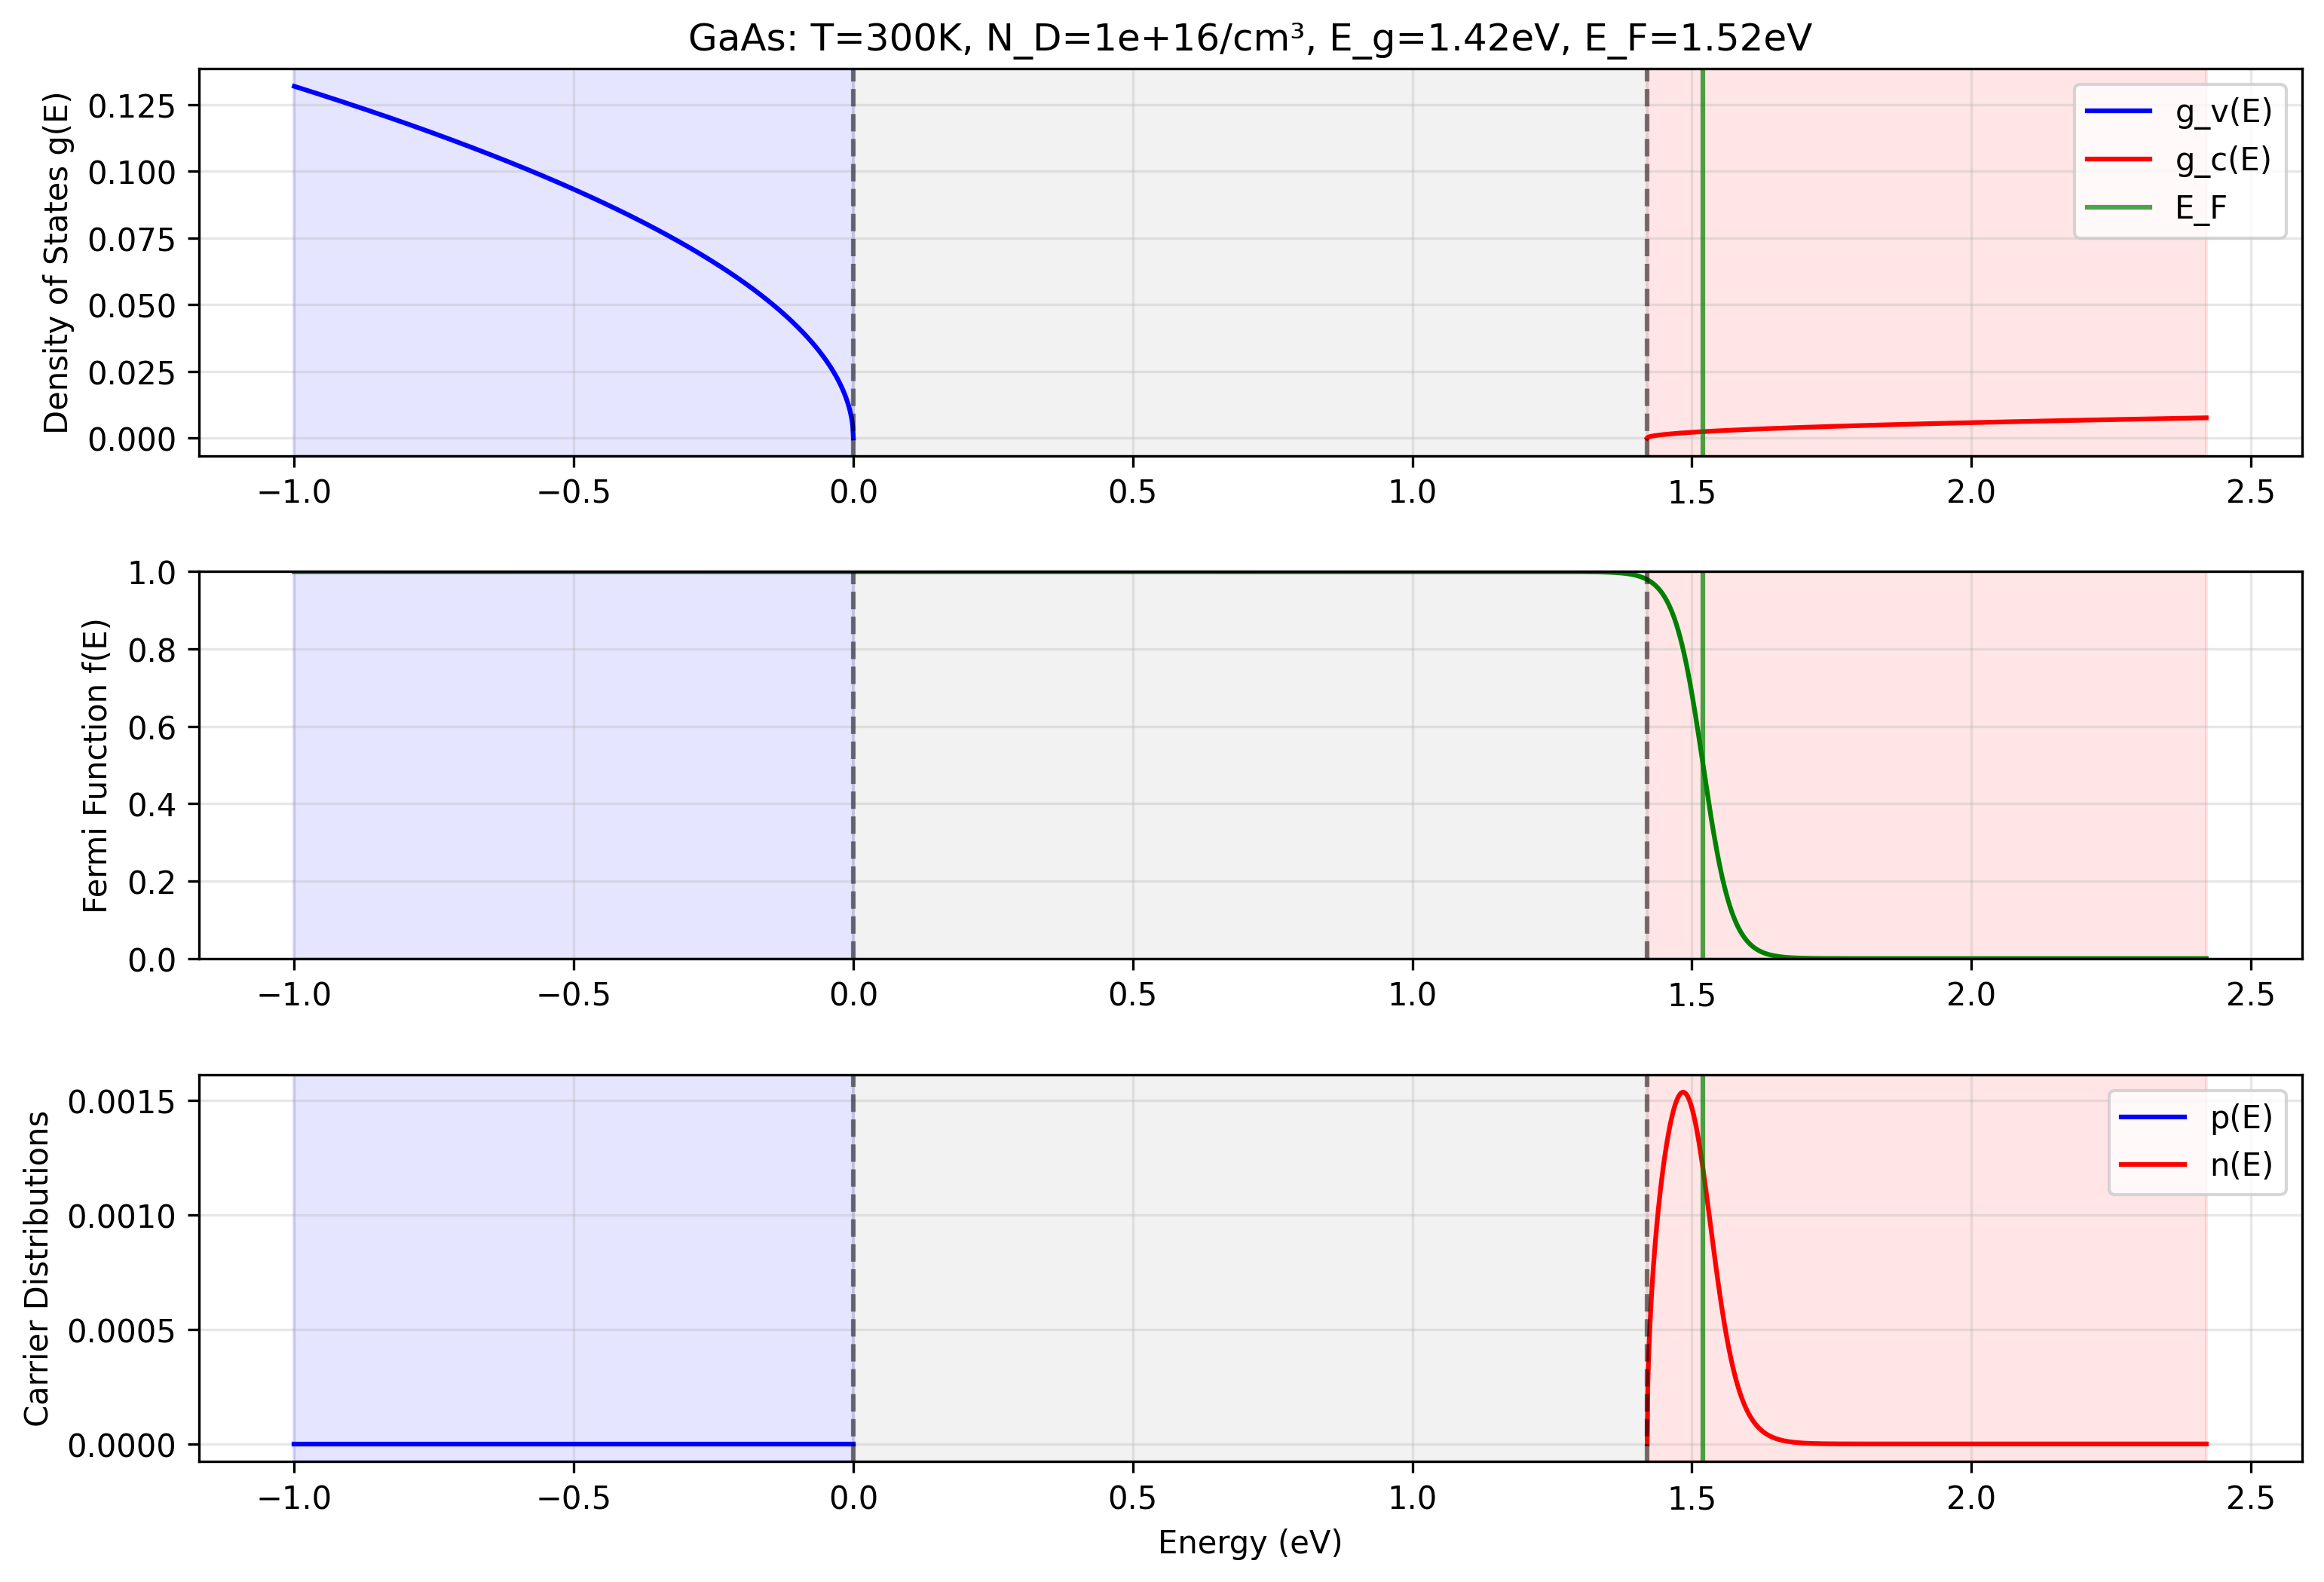

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib import cm
import math

# Physical constants
k_B = 8.617333262e-5  # Boltzmann constant in eV/K
h_bar = 6.582119569e-16  # Reduced Planck constant in eV·s
m_0 = 9.1093837e-31  # Electron rest mass in kg

# Material parameters - effective masses as ratios of electron rest mass
materials = {
    "Si": {"m_e": 1.08, "m_h": 0.56, "E_g": 1.12},
    "Ge": {"m_e": 0.55, "m_h": 0.37, "E_g": 0.66},
    "GaAs": {"m_e": 0.067, "m_h": 0.45, "E_g": 1.42}
}

def density_of_states(E, E_edge, m_eff):
    """Calculate density of states g(E)"""
    if isinstance(E, np.ndarray):
        result = np.zeros_like(E)
        valid = E >= E_edge
        # g(E) ∝ sqrt(E - E_edge) * m_eff^(3/2)
        result[valid] = (m_eff*m_0)**(3/2) * np.sqrt(2) / (np.pi**2 * h_bar**3) * np.sqrt(E[valid] - E_edge)
        return result
    else:
        if E < E_edge:
            return 0
        return (m_eff*m_0)**(3/2) * np.sqrt(2) / (np.pi**2 * h_bar**3) * np.sqrt(E - E_edge)

def fermi_dirac(E, E_F, T):
    """Calculate Fermi-Dirac distribution f(E)"""
    if T < 1:  # Avoid division by zero for T=0K case
        # At T=0K, f(E) is a step function
        if isinstance(E, np.ndarray):
            result = np.zeros_like(E)
            result[E <= E_F] = 1.0
            return result
        else:
            return 1.0 if E <= E_F else 0.0
    
    # For T > 0K, use the Fermi-Dirac formula
    if isinstance(E, np.ndarray):
        return 1.0 / (1.0 + np.exp((E - E_F) / (k_B * T)))
    else:
        return 1.0 / (1.0 + np.exp((E - E_F) / (k_B * T)))

def calculate_fermi_level(N_D, material, T):
    """Estimate the Fermi level based on doping density"""
    # For simplicity, assuming n-type semiconductor
    # E_F = E_c - k_B*T*ln(N_c/N_D)
    # where N_c is the effective density of states in the conduction band
    m_e = material["m_e"] * m_0
    N_c = 2 * (2 * np.pi * m_e * k_B * T / (h_bar**2))**(3/2)
    
    if N_D == 0:
        # Intrinsic semiconductor
        return material["E_g"] / 2
    
    # Simple estimation for n-type
    E_F = material["E_g"] - k_B * T * np.log(N_c / N_D)
    
    # Limit the Fermi level to reasonable values
    if E_F > material["E_g"]:
        E_F = material["E_g"] + 0.1  # Degenerate n-type
    elif E_F < 0:
        E_F = 0.1  # Degenerate p-type
    
    return E_F

def plot_semiconductor_physics(material_name, T, N_D):
    """Create plots for semiconductor physics for given parameters"""
    material = materials[material_name]
    E_g = material["E_g"]  # Energy gap in eV
    m_e = material["m_e"]  # Effective electron mass
    m_h = material["m_h"]  # Effective hole mass
    
    # Calculate Fermi level based on doping
    E_F = calculate_fermi_level(N_D, material, T)
    
    # Energy ranges for valence and conduction bands
    E_v = np.linspace(-1.0, 0.0, 1000)  # Valence band (shifted so top is at E=0)
    E_c = np.linspace(E_g, E_g + 1.0, 1000)  # Conduction band
    
    # Calculate density of states for each band
    g_v = density_of_states(-E_v, 0, m_h)  # For valence band, energy increases downward
    g_c = density_of_states(E_c, E_g, m_e)  # For conduction band
    
    # Calculate Fermi-Dirac distribution
    E_all = np.linspace(-1.0, E_g + 1.0, 2000)
    f_E = fermi_dirac(E_all, E_F, T)
    
    # Calculate carrier distributions
    n_E = g_c * fermi_dirac(E_c, E_F, T)  # Electrons in conduction band
    p_E = g_v * (1 - fermi_dirac(E_v, E_F, T))  # Holes in valence band
    
    # Create plot
    fig = plt.figure(figsize=(12, 8))
    gs = GridSpec(3, 1, height_ratios=[1, 1, 1], hspace=0.3)
    
    # Plot density of states
    ax1 = fig.add_subplot(gs[0])
    ax1.plot(E_v, g_v, 'b-', label='g_v(E)')
    ax1.plot(E_c, g_c, 'r-', label='g_c(E)')
    ax1.axvspan(-1.0, 0, alpha=0.1, color='blue')
    ax1.axvspan(E_g, E_g + 1.0, alpha=0.1, color='red')
    ax1.axvspan(0, E_g, alpha=0.1, color='gray')
    ax1.axvline(x=0, color='k', linestyle='--', alpha=0.5)
    ax1.axvline(x=E_g, color='k', linestyle='--', alpha=0.5)
    ax1.axvline(x=E_F, color='g', linestyle='-', alpha=0.7, label='E_F')
    ax1.set_ylabel('Density of States g(E)')
    ax1.set_title(f'{material_name}: T={T}K, N_D={N_D}/cm³, E_g={E_g}eV, E_F={E_F:.2f}eV')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot Fermi-Dirac distribution
    ax2 = fig.add_subplot(gs[1])
    ax2.plot(E_all, f_E, 'g-', label='f(E)')
    ax2.axvspan(-1.0, 0, alpha=0.1, color='blue')
    ax2.axvspan(E_g, E_g + 1.0, alpha=0.1, color='red')
    ax2.axvspan(0, E_g, alpha=0.1, color='gray')
    ax2.axvline(x=0, color='k', linestyle='--', alpha=0.5)
    ax2.axvline(x=E_g, color='k', linestyle='--', alpha=0.5)
    ax2.axvline(x=E_F, color='g', linestyle='-', alpha=0.7)
    ax2.set_ylabel('Fermi Function f(E)')
    ax2.set_ylim(0, 1)
    ax2.grid(True, alpha=0.3)
    
    # Plot carrier distributions
    ax3 = fig.add_subplot(gs[2])
    ax3.plot(E_v, p_E, 'b-', label='p(E)')
    ax3.plot(E_c, n_E, 'r-', label='n(E)')
    ax3.axvspan(-1.0, 0, alpha=0.1, color='blue')
    ax3.axvspan(E_g, E_g + 1.0, alpha=0.1, color='red')
    ax3.axvspan(0, E_g, alpha=0.1, color='gray')
    ax3.axvline(x=0, color='k', linestyle='--', alpha=0.5)
    ax3.axvline(x=E_g, color='k', linestyle='--', alpha=0.5)
    ax3.axvline(x=E_F, color='g', linestyle='-', alpha=0.7)
    ax3.set_xlabel('Energy (eV)')
    ax3.set_ylabel('Carrier Distributions')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    plt.tight_layout()
    return fig

def part_a_temperature_variation(material_name="Si"):
    """Show how diagrams change at different temperatures"""
    temperatures = [0, 100, 300, 1000]  # in Kelvin
    N_D = 1e16  # Fixed doping density
    
    figs = []
    for T in temperatures:
        fig = plot_semiconductor_physics(material_name, T, N_D)
        figs.append(fig)
        plt.close(fig)  # Close the figure to avoid display in notebook
    
    # Create a 2x2 subplot figure
    fig_combined = plt.figure(figsize=(15, 12))
    
    for i, (fig, T) in enumerate(zip(figs, temperatures)):
        for j in range(3):  # Each original figure has 3 subplots
            ax_original = fig.axes[j]
            ax_new = fig_combined.add_subplot(3, 4, i + 1 + j*4)
            
            # Copy content from original axes to new axes
            for line in ax_original.lines:
                ax_new.plot(line.get_xdata(), line.get_ydata(), 
                           color=line.get_color(), 
                           linestyle=line.get_linestyle(),
                           label=line.get_label())
                
            # Copy spans
            for collection in ax_original.collections:
                if hasattr(collection, 'get_facecolor'):
                    ax_new.axvspan(-1.0, 0, alpha=0.1, color='blue')
                    ax_new.axvspan(materials[material_name]["E_g"], 
                                  materials[material_name]["E_g"] + 1.0, 
                                  alpha=0.1, color='red')
                    ax_new.axvspan(0, materials[material_name]["E_g"], 
                                  alpha=0.1, color='gray')
            
            # Set labels and title
            if j == 0:
                ax_new.set_title(f'T = {T}K')
            if i == 0:
                if j == 0:
                    ax_new.set_ylabel('Density of States g(E)')
                elif j == 1:
                    ax_new.set_ylabel('Fermi Function f(E)')
                elif j == 2:
                    ax_new.set_ylabel('Carrier Distributions')
            if j == 2:
                ax_new.set_xlabel('Energy (eV)')
            
            # Set the y-axis limit for Fermi function plot
            if j == 1:
                ax_new.set_ylim(0, 1)
            
            # Add grid and legend
            ax_new.grid(True, alpha=0.3)
            if j == 0 or j == 2:
                ax_new.legend()
    
    plt.suptitle(f'Part a) Effect of Temperature on {material_name} (N_D = {N_D}/cm³)', fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    return fig_combined

def part_b_doping_variation(material_name="Si"):
    """Show how diagrams change at different doping densities"""
    T = 300  # Fixed temperature in Kelvin
    doping_densities = [1e10, 1e16, 1e21]  # in cm^-3
    
    figs = []
    for N_D in doping_densities:
        fig = plot_semiconductor_physics(material_name, T, N_D)
        figs.append(fig)
        plt.close(fig)  # Close the figure to avoid display in notebook
    
    # Create a figure with subplots
    fig_combined = plt.figure(figsize=(15, 12))
    
    for i, (fig, N_D) in enumerate(zip(figs, doping_densities)):
        for j in range(3):  # Each original figure has 3 subplots
            ax_original = fig.axes[j]
            ax_new = fig_combined.add_subplot(3, 3, i + 1 + j*3)
            
            # Copy content from original axes to new axes
            for line in ax_original.lines:
                ax_new.plot(line.get_xdata(), line.get_ydata(), 
                           color=line.get_color(), 
                           linestyle=line.get_linestyle(),
                           label=line.get_label())
                
            # Copy spans
            for collection in ax_original.collections:
                if hasattr(collection, 'get_facecolor'):
                    ax_new.axvspan(-1.0, 0, alpha=0.1, color='blue')
                    ax_new.axvspan(materials[material_name]["E_g"], 
                                  materials[material_name]["E_g"] + 1.0, 
                                  alpha=0.1, color='red')
                    ax_new.axvspan(0, materials[material_name]["E_g"], 
                                  alpha=0.1, color='gray')
            
            # Set labels and title
            if j == 0:
                ax_new.set_title(f'N_D = {N_D}/cm³')
            if i == 0:
                if j == 0:
                    ax_new.set_ylabel('Density of States g(E)')
                elif j == 1:
                    ax_new.set_ylabel('Fermi Function f(E)')
                elif j == 2:
                    ax_new.set_ylabel('Carrier Distributions')
            if j == 2:
                ax_new.set_xlabel('Energy (eV)')
            
            # Set the y-axis limit for Fermi function plot
            if j == 1:
                ax_new.set_ylim(0, 1)
            
            # Add grid and legend
            ax_new.grid(True, alpha=0.3)
            if j == 0 or j == 2:
                ax_new.legend()
    
    plt.suptitle(f'Part b) Effect of Doping Density on {material_name} (T = {T}K)', fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    return fig_combined

# Generate and display the plots
material_name = "Si"  # Can be changed to "Ge" or "GaAs"

# Part a) Temperature variation
fig_a = part_a_temperature_variation(material_name)
plt.savefig('part_a_temperature_variation.png', dpi=300, bbox_inches='tight')
plt.close(fig_a)

# Part b) Doping variation
fig_b = part_b_doping_variation(material_name)
plt.savefig('part_b_doping_variation.png', dpi=300, bbox_inches='tight')
plt.close(fig_b)

# Display the plots
from IPython.display import Image, display
display(Image(filename='part_a_temperature_variation.png'))
display(Image(filename='part_b_doping_variation.png'))

# You can also generate plots for different materials
materials_to_plot = ["Si", "Ge", "GaAs"]
for material in materials_to_plot:
    fig = plot_semiconductor_physics(material, T=300, N_D=1e16)
    plt.savefig(f'{material}_properties.png', dpi=300, bbox_inches='tight')
    plt.close(fig)
    display(Image(filename=f'{material}_properties.png'))